In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import torch.nn as tnn
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [3]:
# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [4]:
data = pd.read_csv('../data/gata1_remap.tsv.gz', sep=',')
data.columns = ['id', 'loc', 'seq', 'target']
misreads = []
for index, seq in enumerate(data['seq']):
    if seq.replace('A', '').replace('C', '').replace('G', '').replace('T', '') is not '':
        misreads.append(index)
data = data.drop(misreads)
data.index = range(len(data))

train_10000_dataframe = data.sample(n=10000)
train_1000_dataframe = train_10000_dataframe.sample(n=1000)
train_100_dataframe = train_1000_dataframe.sample(n=100)
train_10_dataframe = train_100_dataframe.sample(n=10)
train_4_dataframe = train_10_dataframe.sample(n=4)
train_1_dataframe = train_4_dataframe.sample(n=1)

train_1_dataframe.index = range(1)
train_4_dataframe.index = range(4)
train_10_dataframe.index = range(10)
train_100_dataframe.index = range(100)
train_1000_dataframe.index = range(1000)
train_10000_dataframe.index = range(10000)

# train_data = mb.tl.ChipSeqDataset(data_frame=data)
# train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
train_1_data = mb.tl.ChipSeqDataset(data_frame=train_1_dataframe)
train_1_loader = tdata.DataLoader(dataset=train_1_data, batch_size=1, shuffle=False)
train_4_data = mb.tl.ChipSeqDataset(data_frame=train_4_dataframe)
train_4_loader = tdata.DataLoader(dataset=train_4_data, batch_size=4, shuffle=False)
train_10_data = mb.tl.ChipSeqDataset(data_frame=train_10_dataframe)
train_10_loader = tdata.DataLoader(dataset=train_10_data, batch_size=10, shuffle=False)
train_100_data = mb.tl.ChipSeqDataset(data_frame=train_100_dataframe)
train_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=10, shuffle=True)
test_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=1, shuffle=False)
train_1000_data = mb.tl.ChipSeqDataset(data_frame=train_1000_dataframe)
train_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=64, shuffle=True)
test_1000_loader = tdata.DataLoader(dataset=train_1000_data, batch_size=1, shuffle=False)
train_10000_data = mb.tl.ChipSeqDataset(data_frame=train_10000_dataframe)
train_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=256, shuffle=True)
test_10000_loader = tdata.DataLoader(dataset=train_10000_data, batch_size=1, shuffle=False)

In [5]:
net = mb.tl.Network_PB().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()
loss_history = []

0.13533528
0.13533528


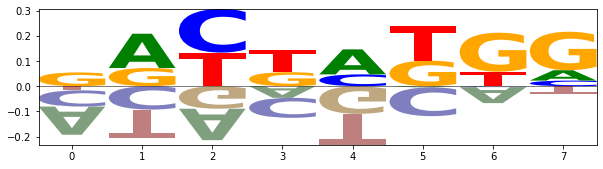

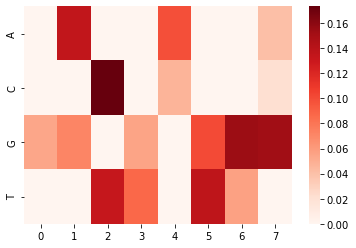

In [6]:
# for both scaling-weights, the log-value is saved s.t. the final scaling is positive. 
# For the first one it doesn't seem to change much, but for the second one posivity is necessary
print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))  # weight before the exp. fct.
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))  # weight after the exp. fct.
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

In [7]:
# optimiser = topti.Adam(net.parameters(), lr=0.00001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 1.644
Epoch:  2, Loss: 1.633
Epoch:  3, Loss: 1.608
Epoch:  4, Loss: 1.576
Epoch:  5, Loss: 1.575
Epoch:  6, Loss: 1.550
Epoch:  7, Loss: 1.531
Epoch:  8, Loss: 1.508
Epoch:  9, Loss: 1.498
Epoch: 10, Loss: 1.467
Epoch: 11, Loss: 1.457
Epoch: 12, Loss: 1.435
Epoch: 13, Loss: 1.409
Epoch: 14, Loss: 1.384
Epoch: 15, Loss: 1.362
Epoch: 16, Loss: 1.334
Epoch: 17, Loss: 1.313
Epoch: 18, Loss: 1.289
Epoch: 19, Loss: 1.263
Epoch: 20, Loss: 1.237
Epoch: 21, Loss: 1.205
Epoch: 22, Loss: 1.176
Epoch: 23, Loss: 1.141
Epoch: 24, Loss: 1.119
Epoch: 25, Loss: 1.095
Epoch: 26, Loss: 1.060
Epoch: 27, Loss: 1.029
Epoch: 28, Loss: 1.000
Epoch: 29, Loss: 0.967
Epoch: 30, Loss: 0.937
Epoch: 31, Loss: 0.910
Epoch: 32, Loss: 0.882
Epoch: 33, Loss: 0.859
Epoch: 34, Loss: 0.834
Epoch: 35, Loss: 0.815
Epoch: 36, Loss: 0.792
Epoch: 37, Loss: 0.776
Epoch: 38, Loss: 0.761
Epoch: 39, Loss: 0.743
Epoch: 40, Loss: 0.735
Epoch: 41, Loss: 0.724
Epoch: 42, Loss: 0.718
Epoch: 43, Loss: 0.712
Epoch: 44, 

0.39612582
0.075644836


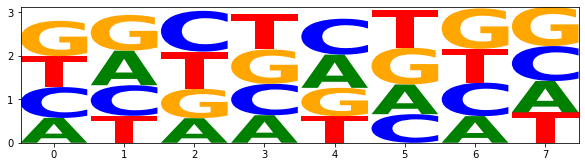

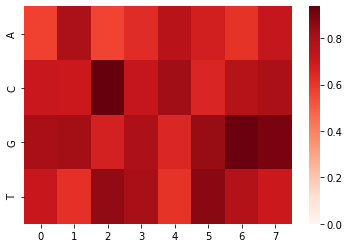

In [8]:
# During the plateau
print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

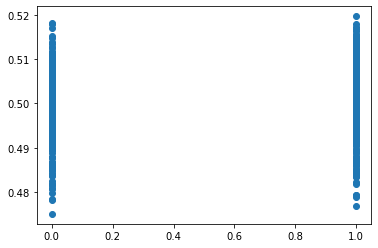

In [9]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.5014919
0.5019299


<AxesSubplot:>

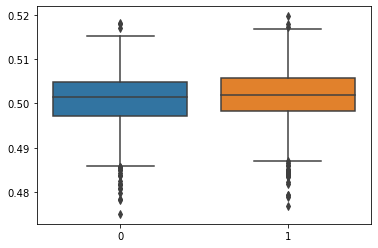

In [10]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [11]:
# training further...
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.692
Epoch:  2, Loss: 0.692
Epoch:  3, Loss: 0.692
Epoch:  4, Loss: 0.692
Epoch:  5, Loss: 0.692
Epoch:  6, Loss: 0.692
Epoch:  7, Loss: 0.692
Epoch:  8, Loss: 0.692
Epoch:  9, Loss: 0.692
Epoch: 10, Loss: 0.692
Epoch: 11, Loss: 0.692
Epoch: 12, Loss: 0.692
Epoch: 13, Loss: 0.692
Epoch: 14, Loss: 0.692
Epoch: 15, Loss: 0.692
Epoch: 16, Loss: 0.692
Epoch: 17, Loss: 0.692
Epoch: 18, Loss: 0.692
Epoch: 19, Loss: 0.692
Epoch: 20, Loss: 0.692
Epoch: 21, Loss: 0.692
Epoch: 22, Loss: 0.692
Epoch: 23, Loss: 0.692
Epoch: 24, Loss: 0.692
Epoch: 25, Loss: 0.692
Epoch: 26, Loss: 0.692
Epoch: 27, Loss: 0.692
Epoch: 28, Loss: 0.692
Epoch: 29, Loss: 0.692
Epoch: 30, Loss: 0.692
Epoch: 31, Loss: 0.692
Epoch: 32, Loss: 0.692
Epoch: 33, Loss: 0.692
Epoch: 34, Loss: 0.692
Epoch: 35, Loss: 0.692
Epoch: 36, Loss: 0.692
Epoch: 37, Loss: 0.692
Epoch: 38, Loss: 0.692
Epoch: 39, Loss: 0.692
Epoch: 40, Loss: 0.692
Epoch: 41, Loss: 0.692
Epoch: 42, Loss: 0.692
Epoch: 43, Loss: 0.692
Epoch: 44, 

In [29]:
# training even further... (I executed this cell repeatedly)
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
net.train()
loss_history += mb.tl.train_network(net, train_1000_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.567
Epoch:  2, Loss: 0.566
Epoch:  3, Loss: 0.568
Epoch:  4, Loss: 0.567
Epoch:  5, Loss: 0.568
Epoch:  6, Loss: 0.569
Epoch:  7, Loss: 0.567
Epoch:  8, Loss: 0.568
Epoch:  9, Loss: 0.568
Epoch: 10, Loss: 0.569
Epoch: 11, Loss: 0.571
Epoch: 12, Loss: 0.571
Epoch: 13, Loss: 0.566
Epoch: 14, Loss: 0.571
Epoch: 15, Loss: 0.570
Epoch: 16, Loss: 0.569
Epoch: 17, Loss: 0.570
Epoch: 18, Loss: 0.571
Epoch: 19, Loss: 0.569
Epoch: 20, Loss: 0.567
Epoch: 21, Loss: 0.569
Epoch: 22, Loss: 0.570
Epoch: 23, Loss: 0.569
Epoch: 24, Loss: 0.569
Epoch: 25, Loss: 0.569
Epoch: 26, Loss: 0.567
Epoch: 27, Loss: 0.567
Epoch: 28, Loss: 0.567
Epoch: 29, Loss: 0.567
Epoch: 30, Loss: 0.568
Epoch: 31, Loss: 0.568
Epoch: 32, Loss: 0.571
Epoch: 33, Loss: 0.569
Epoch: 34, Loss: 0.569
Epoch: 35, Loss: 0.571
Epoch: 36, Loss: 0.566
Epoch: 37, Loss: 0.568
Epoch: 38, Loss: 0.567
Epoch: 39, Loss: 0.569
Epoch: 40, Loss: 0.568
Epoch: 41, Loss: 0.570
Epoch: 42, Loss: 0.569
Epoch: 43, Loss: 0.567
Epoch: 44, 

In order to save the loss values, I did the experiments again. I seems like I was quite lucky to reach 0.53 in my first try. Apart from that, everything looks the same.

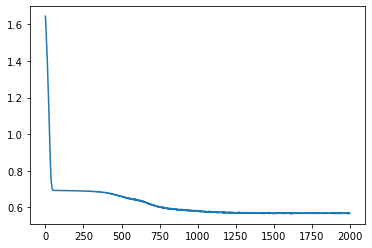

In [30]:
loss_history = np.array(loss_history)
plt.plot(loss_history)

1.3931323
0.084830046


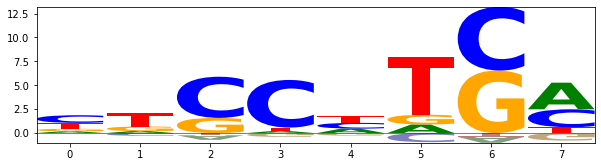

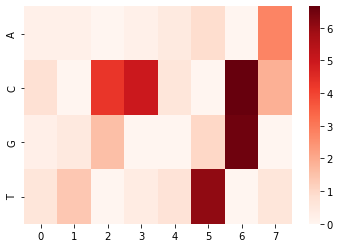

In [31]:
print(np.exp(net.log_weight_1.squeeze().cpu().detach().numpy()))
print(np.exp(net.log_weight_2.squeeze().cpu().detach().numpy()))
mb.tl.create_logo(net)
plt.show()
mb.tl.create_heatmap(net)

<AxesSubplot:>

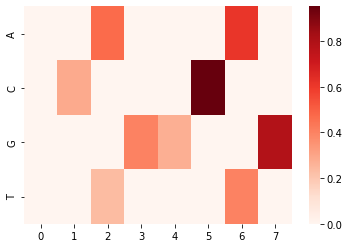

In [34]:
# create a heatmap of the negative weights
weights = -net.conv.weight.squeeze().cpu().detach().numpy()
weights = pd.DataFrame(weights)
weights.index = 'A', 'C', 'G', 'T'
sns.heatmap(weights, cmap='Reds', vmin=0)

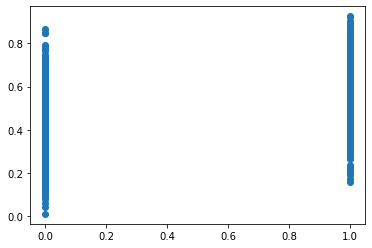

In [32]:
all_targets, all_outputs = [], []
net.eval()
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_1000_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

0.39623365
0.6134679


<AxesSubplot:>

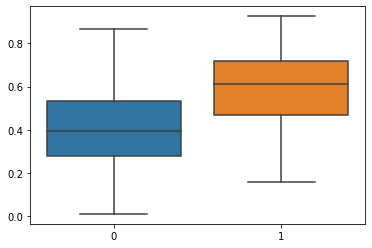

In [33]:
print(np.median(np.array(all_outputs)[np.array(all_targets) == 0]))
print(np.median(np.array(all_outputs)[np.array(all_targets) == 1]))
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))